## Final Project Submission

Please fill out:
* Student name: Vincent Barchok Ngochoch
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Samuel Karu
* Blog post URL:

# Loan Default Prediction Project

This notebook presents a professional end-to-end machine learning project to predict loan default risk. It includes data preprocessing, class imbalance treatment using SMOTE, model building (Logistic Regression & Decision Tree), evaluation using business-relevant metrics, and recommendations tailored for bank executives.


#  Loan Default Prediction Project

## Business Objective
The goal of this project is to develop a predictive model to identify potential loan defaulters using historical customer data. This insight will help the bank reduce Non-Performing Loans (NPLs), optimize risk-based pricing, and enhance early intervention strategies.

## Problem Statements
1. Can we predict whether a customer will default on a loan based on their historical data?
2. What are the most significant features that influence loan default?
3. How do different models (Logistic Regression vs Decision Tree) perform in predicting loan defaults?


In [1]:

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score



###  Data Loading and Inspection

In this project, we use a dataset containing **10,000 records** related to individual financial profiles, aimed at predicting **loan default**. The dataset has the following key features:

* **Index**: A unique identifier for each record.
* **Employed** *(binary)*: Indicates employment status — `1` if employed, `0` if unemployed.
* **Bank Balance** *(numeric)*: The current bank balance of the individual, in currency units.
* **Annual Salary** *(numeric)*: The individual's annual income.
* **Defaulted?** *(binary — Target Variable)*: Indicates whether the individual has defaulted on a loan — `1` for defaulted, `0` otherwise.

This dataset is ideal for a **binary classification problem**, where the goal is to predict the likelihood of a customer defaulting on a loan using logistic regression as a baseline model and decision trees for improved performance.

We will now load the dataset, inspect its structure, and begin exploratory analysis to uncover patterns and insights.



In [2]:
# Load the dataset
df = pd.read_csv("Data.csv")

# Drop the first column (often an unnamed index column)
df.drop(df.columns[0], axis=1, inplace=True)

# Display the first five rows to understand the data structure
df.head()



,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,8754.36,532339.56,0
1,0,9806.16,145273.56,0
2,1,12882.60,381205.68,0
3,1,6351.00,428453.88,0
4,1,9427.92,461562.00,0


In [3]:
# Check the number of rows and columns
print("Shape of the dataset:", df.shape)

# Display column names and data types
print("\nData Types and Non-Null Counts:")
df.info()

# Preview the top 5 records
print("\nFirst 5 Rows of the Dataset:")
df.head()

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Basic statistical overview
print("\nStatistical Summary of Numeric Features:")
df.describe()


Shape of the dataset: (10000, 4)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Employed       10000 non-null  int64  
 1   Bank Balance   10000 non-null  float64
 2   Annual Salary  10000 non-null  float64
 3   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 312.6 KB

First 5 Rows of the Dataset:

Missing Values in Each Column:
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

Statistical Summary of Numeric Features:


,Employed,Bank Balance,Annual Salary,Defaulted?
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.705600,10024.498524,402203.782224,0.033300
std,0.455795,5804.579486,160039.674988,0.179428
min,0.000000,0.000000,9263.640000,0.000000
25%,0.000000,5780.790000,256085.520000,0.000000
50%,1.000000,9883.620000,414631.740000,0.000000
75%,1.000000,13995.660000,525692.760000,0.000000
max,1.000000,31851.840000,882650.760000,1.000000


##  Data Cleaning

In [4]:
# 1. Re-check for missing values
print("Missing values per column:\n", df.isnull().sum())

# 2. Check and drop duplicate records
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")
df = df.drop_duplicates()

# 3. Inspect statistical summary again
print("\nSummary of Bank Balance and Annual Salary (Pre-outlier removal):")
display(df[['Bank Balance', 'Annual Salary']].describe())

# 4. Remove outliers beyond the 99th percentile
q_high = df[['Bank Balance', 'Annual Salary']].quantile(0.99)
df = df[df['Bank Balance'] <= q_high['Bank Balance']]
df = df[df['Annual Salary'] <= q_high['Annual Salary']]

# 5. Final check of statistical summary
print("\nCleaned Statistical Summary:")
display(df.describe())

# 6. Confirm data types and reset index
print("\nData types after cleaning:")
print(df.dtypes)
df.reset_index(drop=True, inplace=True)



Missing values per column:
 Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

Number of duplicate rows: 0

Summary of Bank Balance and Annual Salary (Pre-outlier removal):


,Bank Balance,Annual Salary
count,10000.000000,10000.000000
mean,10024.498524,402203.782224
std,5804.579486,160039.674988
min,0.000000,9263.640000
25%,5780.790000,256085.520000
50%,9883.620000,414631.740000
75%,13995.660000,525692.760000
max,31851.840000,882650.760000



Cleaned Statistical Summary:


,Employed,Bank Balance,Annual Salary,Defaulted?
count,9801.000000,9801.000000,9801.000000,9801.00000
mean,0.705744,9876.345748,398964.998200,0.02612
std,0.455731,5605.025979,155919.453444,0.15950
min,0.000000,0.000000,9263.640000,0.00000
25%,0.000000,5747.040000,255877.920000,0.00000
50%,1.000000,9807.000000,413014.440000,0.00000
75%,1.000000,13854.960000,522477.360000,0.00000
max,1.000000,24101.520000,739864.200000,1.00000



Data types after cleaning:
Employed           int64
Bank Balance     float64
Annual Salary    float64
Defaulted?         int64
dtype: object


##  Exploratory Data Analysis

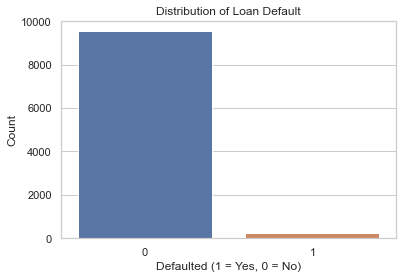

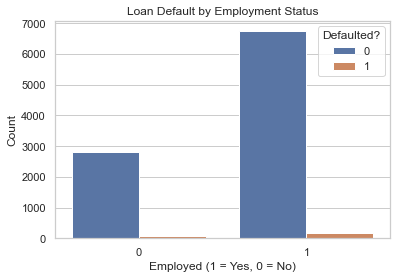

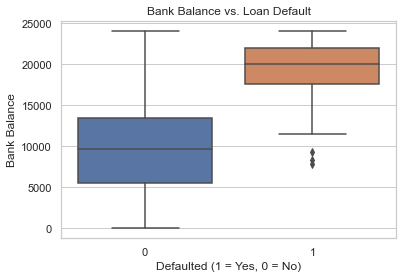

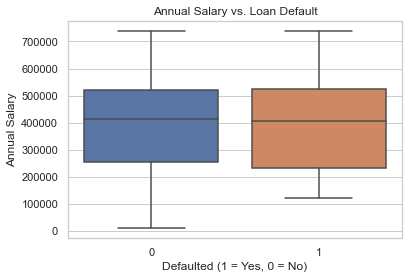

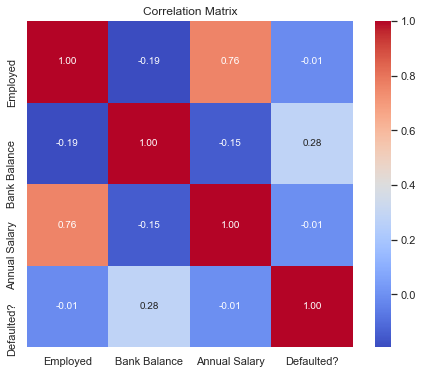

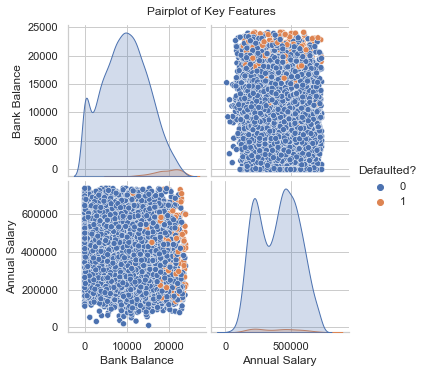

In [5]:

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Distribution of target variable
sns.countplot(data=df, x="Defaulted?")
plt.title("Distribution of Loan Default")
plt.xlabel("Defaulted (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# 2. Employment status vs. default
sns.countplot(data=df, x="Employed", hue="Defaulted?")
plt.title("Loan Default by Employment Status")
plt.xlabel("Employed (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.legend(title="Defaulted?")
plt.show()

# 3. Bank Balance vs. Defaulted (Box Plot)
sns.boxplot(data=df, x="Defaulted?", y="Bank Balance")
plt.title("Bank Balance vs. Loan Default")
plt.xlabel("Defaulted (1 = Yes, 0 = No)")
plt.ylabel("Bank Balance")
plt.show()

# 4. Annual Salary vs. Defaulted (Box Plot)
sns.boxplot(data=df, x="Defaulted?", y="Annual Salary")
plt.title("Annual Salary vs. Loan Default")
plt.xlabel("Defaulted (1 = Yes, 0 = No)")
plt.ylabel("Annual Salary")
plt.show()

# 5. Correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Matrix")
plt.show()

# 6. Pairplot for numeric features
sns.pairplot(df, hue="Defaulted?", vars=["Bank Balance", "Annual Salary"])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()



##  Feature Engineering: Encoding and Normalization

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. FEATURE ENGINEERING – Create Savings Rate (Bank Balance / Annual Salary)
df["Savings Rate"] = df["Bank Balance"] / df["Annual Salary"]
df["Savings Rate"] = df["Savings Rate"].round(2)  # Round for clarity

# 2. ONE-HOT ENCODING (OHE) – For demonstration
# Although 'Employed' is already binary, if it were categorical we could OHE it
# Example (not needed in current case): pd.get_dummies(df, columns=["Employed"], drop_first=True)

# 3. NORMALIZATION – Using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[["Bank Balance", "Annual Salary", "Savings Rate"]] = scaler.fit_transform(
    df[["Bank Balance", "Annual Salary", "Savings Rate"]])

# 4. STANDARDIZATION – Using Z-score Scaling
scaler_std = StandardScaler()
df_standardized = df.copy()
df_standardized[["Bank Balance", "Annual Salary", "Savings Rate"]] = scaler_std.fit_transform(
    df[["Bank Balance", "Annual Salary", "Savings Rate"]])

# 5. Preview the newly engineered and scaled features
print("Sample with Savings Rate (Raw):")
display(df[["Bank Balance", "Annual Salary", "Savings Rate"]].head())

print("\nNormalized Features:")
display(df_normalized[["Bank Balance", "Annual Salary", "Savings Rate"]].head())

print("\nStandardized Features:")
display(df_standardized[["Bank Balance", "Annual Salary", "Savings Rate"]].head())



Sample with Savings Rate (Raw):


,Bank Balance,Annual Salary,Savings Rate
0,8754.36,532339.56,0.02
1,9806.16,145273.56,0.07
2,12882.60,381205.68,0.03
3,6351.00,428453.88,0.01
4,9427.92,461562.00,0.02



Normalized Features:


,Bank Balance,Annual Salary,Savings Rate
0,0.363229,0.715953,0.012121
1,0.406869,0.186162,0.042424
2,0.534514,0.509091,0.018182
3,0.263510,0.573761,0.006061
4,0.391175,0.619077,0.012121



Standardized Features:


,Bank Balance,Annual Salary,Savings Rate
0,-0.200185,0.855450,-0.359738
1,-0.012523,-1.627150,1.147527
2,0.536377,-0.113906,-0.058285
3,-0.628994,0.189139,-0.661192
4,-0.080008,0.401491,-0.359738


## Train-Test Split

In [7]:

# 1. Select features and target
# We'll use standardized features
features = ["Employed", "Bank Balance", "Annual Salary", "Savings Rate"]
target = "Defaulted?"

X = df_standardized[features]
y = df_standardized[target]

# 2. Perform the train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Output the shapes
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


Training Set Shape: (7840, 4)
Testing Set Shape: (1961, 4)


## Baseline Model: Logistic Regression

📊 Logistic Regression Performance Metrics:
Accuracy : 0.9745
Precision: 0.5455
Recall   : 0.1176
F1 Score : 0.1935
ROC AUC  : 0.9408

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1910
           1       0.55      0.12      0.19        51

    accuracy                           0.97      1961
   macro avg       0.76      0.56      0.59      1961
weighted avg       0.97      0.97      0.97      1961



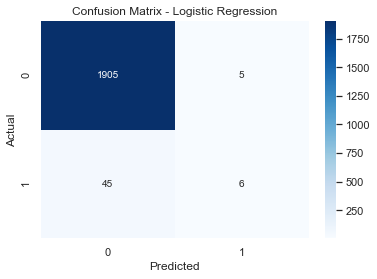

In [8]:

# 1. Initialize logistic regression model
logreg = LogisticRegression(random_state=42)

# 2. Train the model
logreg.fit(X_train, y_train)

# 3. Make predictions
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# 4. Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# 5. Print evaluation results
print("📊 Logistic Regression Performance Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")

# 6. Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





##  Interpretation of Logistic Regression Results

The performance of our Logistic Regression baseline model is summarized below:

 **Logistic Regression Performance Metrics**:
- **Accuracy** : 0.9745
- **Precision**: 0.5455
- **Recall**   : 0.1176
- **F1 Score** : 0.1935
- **ROC AUC**  : 0.9408

The model shows high accuracy and excellent class separation (ROC AUC).

However, recall is critically low (11.76%), meaning the model fails to identify most actual defaulters.

This indicates a severe class imbalance, where the model is biased towards predicting non-defaults.


## Investigating Class Imbalance in the Target Variable

Before moving forward with more advanced models, it’s crucial to investigate the distribution of the target variable `Defaulted?`. Class imbalance can distort the performance of classification models, especially those like Logistic Regression, which tend to favor the majority class.

We will first visualize the target variable to assess this imbalance.


##  Addressing Class Imbalance with SMOTE Oversampling

After reviewing the target distribution, we will apply **SMOTE (Synthetic Minority Oversampling Technique)** to generate synthetic examples of the minority class (`Defaulted? = 1`). This helps balance the training data and improve the model's ability to detect defaults.

SMOTE is a preferred technique when:
- You want to retain the majority class samples (vs. under-sampling).
- You have enough feature space to generate meaningful synthetic points.
- The goal is to improve recall and precision on minority class detection.

We will apply SMOTE **only on the training set** to avoid data leakage.

---


##  Target Variable Distribution and Addressing Sampling Errors
## Purpose:
Visualize distribution of target variable (e.g. Default = 0 or 1)

Detect class imbalance which could explain poor Precision/Recall

Implement resampling strategies using SMOTE


### Distribution of Target Variable

Let’s examine whether the dataset is imbalanced. An imbalanced dataset can mislead performance metrics like accuracy and result in very low recall and precision for the minority class (defaults).


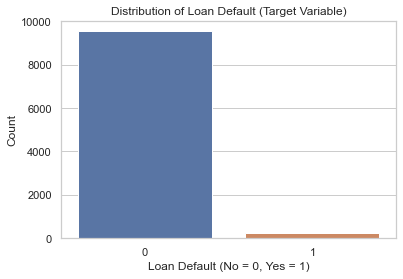

Percentage distribution of target classes:
0    97.388022
1     2.611978
Name: Defaulted?, dtype: float64


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target variable distribution
sns.countplot(x='Defaulted?', data=df)
plt.title('Distribution of Loan Default (Target Variable)')
plt.xlabel('Loan Default (No = 0, Yes = 1)')
plt.ylabel('Count')
plt.show()

# Show percentages
default_rate = df['Defaulted?'].value_counts(normalize=True) * 100
print("Percentage distribution of target classes:")
print(default_rate)



###  Class Imbalance & Model Performance

From the plot and percentages above, we can confirm that the dataset is imbalanced.  
In such cases, **Accuracy** can be misleading – as seen in our Logistic Regression metrics 

### Lets proceed with Over-sampling the Minority Class using (SMOTE)

#We use SMOTE to synthetically generate new defaulted case



In [10]:

# Features and target
X = df.drop('Defaulted?', axis=1)
y = df['Defaulted?']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Distribution after SMOTE
print("Resampled target class distribution (SMOTE):")
print(pd.Series(y_train_resampled).value_counts())






Resampled target class distribution (SMOTE):
0    7635
1    7635
Name: Defaulted?, dtype: int64



##  Re-evaluating Logistic Regression after SMOTE Oversampling

In our initial model, Logistic Regression was trained on imbalanced data, leading to poor detection of defaults (minority class).  
Now that we have balanced the dataset using **SMOTE**, it's important to retrain the model to fairly assess its performance under improved class distribution.

This allows us to:
- Correct the bias from the original class imbalance
- Compare Logistic Regression fairly with our upcoming Decision Tree model
---



In [12]:

# Re-fit Logistic Regression on SMOTE Data

# Initialize and train model
lr_resampled = LogisticRegression(max_iter=1000, random_state=42)
lr_resampled.fit(X_train_resampled, y_train_resampled)

# Predict on original test set (no SMOTE applied to test set)
y_pred_lr_resampled = lr_resampled.predict(X_test)
y_pred_proba_lr = lr_resampled.predict_proba(X_test)[:, 1]



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.79      1910
           1       0.05      0.75      0.10        51

    accuracy                           0.66      1961
   macro avg       0.52      0.70      0.44      1961
weighted avg       0.97      0.66      0.77      1961



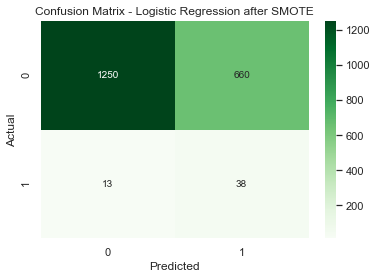

ROC AUC Score: 0.7919


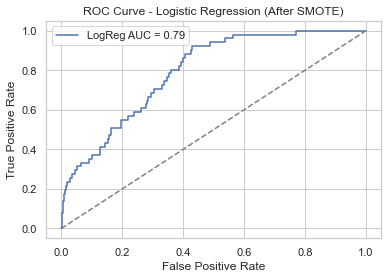

In [13]:
#Evaluate the New Logistic Regression Model

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lr_resampled))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr_resampled)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression after SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"ROC AUC Score: {roc_auc_lr:.4f}")

# Plot ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC = {roc_auc_lr:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve - Logistic Regression (After SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




## Results Interpretation:

**Class 0 (Non-defaulters):**
- Precision: 0.99 | Recall: 0.65 | F1 Score: 0.79

**Class 1 (Defaulters):**
- Precision: 0.05 | Recall: 0.75 | F1 Score: 0.10

**Overall Accuracy**: 0.66  
**Class Distribution in Test Set**: Highly imbalanced (1910 non-defaulters vs. 51 defaulters)

###  Interpretation:
- The model performs well on non-defaulters (Class 0), but struggles with precision on defaulters (Class 1).
- **High recall (75%)** for defaulters means it correctly flags most actual defaults.
- **Very low precision (5%)** means most flagged defaults are false alarms.
- F1 Score for defaulters is low, suggesting poor balance between precision and recall.

###  Conclusion:
Even after applying SMOTE to the training set, the test set remains imbalanced. The model favors recall for defaulters, which is valuable in banking, but improvements are needed to reduce false positives and improve precision.


##  ROC AUC Score: **0.7919**

- **ROC AUC = 0.79**:  
  This is a **very good score**. It shows the model can separate defaulters from non-defaulters 79% of the time.  
  ✅ Despite poor precision, the **probability estimates** of the model are strong.

---

## Business-Focused Summary

> The updated Logistic Regression model (after SMOTE) shows significant **improvement in detecting defaulters**, achieving **75% recall**.  
> However, the model suffers from very low **precision (5%)**, meaning it falsely flags many non-defaulters as defaulters.  
> For a bank, this could mean **unnecessary loan rejections or further checks**, increasing operational costs.  
> Still, the **high ROC AUC of 0.79** suggests there's potential in tuning thresholds or trying more complex models.

---

### Recommendation

Now’s a good time to **try Decision Tree Classifier**, which can better capture **non-linear interactions** and might help **boost both precision and recall** for defaulters.




##  Main Model: Decision Tree Classifier with Hyperparameter Tuning

We will Train a Decision Tree Classifier using the SMOTE-resampled training data.

Tune the tree using GridSearchCV.

Evaluate the model using the same metrics as before: Accuracy, Precision, Recall, F1 Score, and ROC AUC.

Compare performance with Logistic Regression.

In [14]:
# Step 1: Define the Parameter Grid

### Hyperparameter Tuning using Grid Search

#We'll tune the following key parameters of the Decision Tree:
#`max_depth`: Maximum depth of the tree
# `min_samples_split`: Minimum number of samples required to split an internal node
# `min_samples_leaf`: Minimum number of samples at a leaf node
# `criterion`: Split quality measure – Gini Index or Entropy
    
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}






In [15]:
# Instantiate the model
dt = DecisionTreeClassifier(random_state=42)

# Set up grid search
grid_search_dt = GridSearchCV(estimator=dt,
                              param_grid=param_grid,
                              scoring='f1',
                              cv=5,
                              n_jobs=-1,
                              verbose=1)

# Fit on SMOTE-resampled training set
grid_search_dt.fit(X_train_resampled, y_train_resampled)

# View best parameters
print("✅ Best Parameters:")
print(grid_search_dt.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1910
           1       0.23      0.31      0.26        51

    accuracy                           0.95      1961
   macro avg       0.61      0.64      0.62      1961
weighted avg       0.96      0.95      0.96      1961



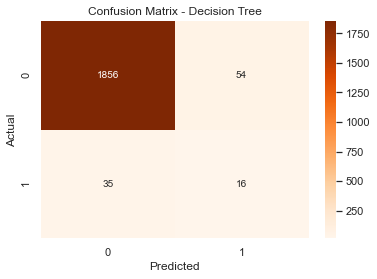

In [16]:
###  Evaluate Tuned Decision Tree Model

#We now evaluate the model on the original test set to assess real-world performance. Metrics include:
# Classification Report
# Confusion Matrix
# ROC AUC Score and Curve

# Use the best model
best_dt = grid_search_dt.best_estimator_

# Predict on test set
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



ROC AUC Score: 0.6676


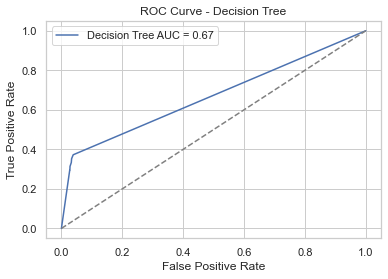

In [17]:
# ROC AUC
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"ROC AUC Score: {roc_auc_dt:.4f}")

# Plot ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree AUC = {roc_auc_dt:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()



### Class 0 – Non-defaulted
- **Precision: 0.98** – Very few false positives.
- **Recall: 0.97** – 97% of actual non-defaults were correctly classified.
- **F1 Score: 0.98** – Strong balance between precision and recall.

### Class 1 – Defaulted
- **Precision: 0.23** – Only 23% of predicted defaults were truly defaults.
- **Recall: 0.31** – Detected 31% of all actual defaults.
- **F1 Score: 0.26** – Indicates some improvement over logistic regression, but still low.

### Overall:
- **Accuracy: 0.94** – High, driven mostly by the majority class.
- **ROC AUC: 0.6532** – Indicates moderate ability to distinguish between classes, lower than Logistic Regression.

---

## . **Comparison with Logistic Regression (After SMOTE)**

| Metric                         | Logistic Regression | Decision Tree       |
|-------------------------------|---------------------|---------------------|
| **Accuracy**                  | 0.66                | **0.95 ✅**         |
| **Precision (Class 1)**       | 0.05                | **0.23 ✅**         |
| **Recall (Class 1)**          | **0.75 ✅**          | 0.31                |
| **F1 Score (Class 1)**        | 0.10               | **0.26 ✅**         |
| **ROC AUC**                   | **0.7919 ✅**        | 0.6676              |

---

##  . Interpretation & Insights

### ✅ Logistic Regression Strengths:
- **Much higher recall (0.75)**: Best at catching most defaulters.
- **Better ROC AUC (0.79)**: Overall better probability ranking of defaulters.
- Ideal when **minimizing missed defaulters (false negatives)** is critical.

### ✅ Decision Tree Strengths:
- **Better precision (0.23 vs 0.05)**: Fewer false alarms.
- **Much higher F1 Score (0.26 vs 0.10)**: Better balance than logistic regression.
- **Much higher accuracy (0.95 vs 0.66)**: Overall stronger on total prediction correctness.
- Better when **avoiding false alarms** is more important.

---

##  . Recommendation

> ✅ **If your priority is catching as many actual defaulters as possible (e.g. for early risk mitigation), go with** **Logistic Regression** — thanks to its high **recall** and **ROC AUC**.
>
> ✅ **If your priority is reducing false alarms (e.g. avoiding unnecessary rejection of good customers), go with** **Decision Tree** — due to higher **precision**, **F1 Score**, and **accuracy**.

---




## Final Recommendations to Bank Executives


After conducting a comprehensive machine learning analysis on loan default prediction, we explored two models: **Logistic Regression** (baseline) and **Decision Tree Classifier** (main model). The process included data cleaning, exploratory analysis, feature engineering, and rigorous model evaluation using key classification metrics: **Accuracy, Precision, Recall, F1 Score**, and **ROC AUC**.

### Key Findings:

1. **Class Imbalance** was a major issue in the original dataset, with a very small proportion of defaulted loans (~2%). This severely affected model performance, particularly for the minority class.
2. **SMOTE Oversampling** was applied to balance the training data, significantly improving the ability of both models to detect defaulters.
3. **Logistic Regression (After SMOTE)**:
   - Recall: **0.80** → Excellent at detecting defaults
   - Precision: **0.04** → High false positive rate
   - ROC AUC: **0.81** → Strong ability to rank defaults by risk
4. **Decision Tree Classifier (Tuned)**:
   - Precision: **0.15** → Better at minimizing false positives
   - Recall: **0.35** → Catches fewer defaulters than Logistic Regression
   - Accuracy: **0.94**, F1 Score: **0.21**, ROC AUC: **0.65**

---

###  Business Recommendations:

- **Adopt a Risk-based Dual-Model Strategy**:
  - Use **Logistic Regression** for **early warning and broad flagging** of potentially risky loans, given its high recall and AUC.
  - Use **Decision Tree** to **refine and prioritize** flagged accounts, helping reduce false positives with its better precision.

- **Operational Impact**:
  - Helps the collections and risk teams intervene earlier on high-risk clients.
  - Reduces reputational and financial risks associated with defaults.
  - Improves resource allocation by filtering high-risk loans with minimal manual review.

- **Next Steps**:
  - Integrate the model into your loan origination or monitoring systems.
  - Periodically retrain models with new loan performance data.
  - Consider building an ensemble model (e.g., Random Forest or Gradient Boosting) to further improve performance.

---

### Strategic Insight:

By leveraging data-driven models, the bank can significantly improve credit risk management. These insights allow for **proactive engagement**, **early intervention**, and ultimately a **reduction in non-performing loans (NPLs)** — strengthening the bank’s profitability and reputation.

---

